### Scikit-Optimize (scopt) distributions


The stochastic expressions currently recognized by scopt's optimization algorithms are:

*space.Integer(low, high, transform=None, name=None)*
- Search space dimension that can take on integer values.
- Parameters
    - low [int]: Lower bound (inclusive).
    - high [int]: Upper bound (inclusive).
    - transform ["identity", "normalize", optional]: The following transformations are supported.
        - "identity", (default) the transformed space is the same as the original space. 
        - "normalize", the transformed space is scaled to be between 0 and 1. 
    - name [str or None]: Name associated with dimension, e.g., "number of trees".

<BR>

*space.Real(low, high, prior='uniform', transform=None, name=None)*
- Search space dimension that can take on any real value.
- Parameters
    - low [float]: Lower bound (inclusive).
    - high [float]: Upper bound (inclusive).
    - prior ["uniform" or "log-uniform", default="uniform"]: Distribution to use when sampling random points for this dimension.
        - If "uniform", points are sampled uniformly between the lower and upper bounds.
        - If "log-uniform", points are sampled uniformly between log10(lower) and log10(upper).`
    - transform ["identity", "normalize", optional]: The following transformations are supported.
        - "identity", (default) the transformed space is the same as the original space.
        - "normalize", the transformed space is scaled to be between 0 and 1.
    - name [str or None]: Name associated with the dimension, e.g., "learning rate".

<BR>
    
*space.Categorical(categories, prior=None, transform=None, name=None)*
- Search space dimension that can take on categorical values.
- Parameters
    - categories [list, shape=(n_categories,)]: Sequence of possible categories.
    - prior [list, shape=(categories,), default=None]: Prior probabilities for each category. By default all categories are equally likely.
    - transform ["onehot", "identity", default="onehot"] :
        - "identity", the transformed space is the same as the original space.
        - "onehot", the transformed space is a one-hot encoded representation of the original space.
    - name [str or None]: Name associated with dimension, e.g., "colors".

### Visualising the data distribution API

In [1]:
from skopt.space import Real, Categorical, Integer

In [2]:
import matplotlib.pyplot as plt

def plot_samples(samples, bins):
    plt.hist(samples, bins = bins, edgecolor = 'black'); 
    plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

#### Integer

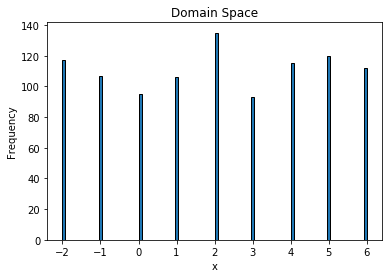

In [3]:
# Create the domain space
space = Integer(-2, 6, name='x')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

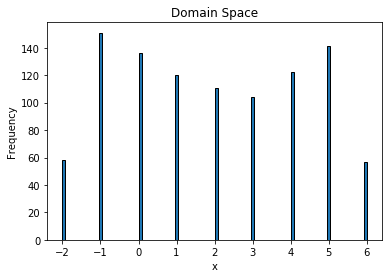

In [4]:
space = Integer(-2, 6, name='x', transform='normalize')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

#### Real

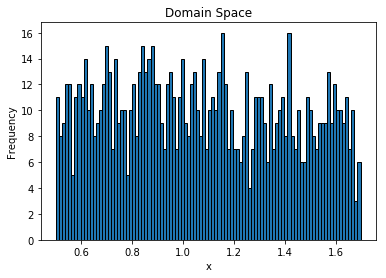

In [5]:
space = Real(0.5, 1.7, name='x', prior='uniform')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

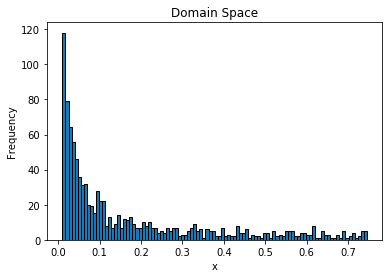

In [6]:
space = Real(0.01, 0.75, name='x', prior='log-uniform')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

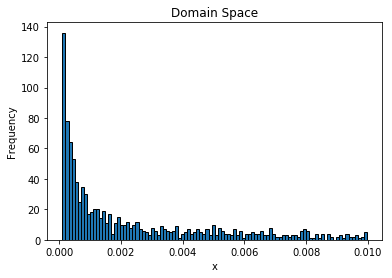

In [7]:
space = Real(10**-4, 10**-2, name='x',  prior='log-uniform')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

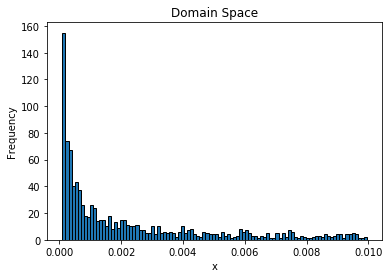

In [8]:
space = Real(10**-4, 10**-2, name='x',  prior='log-uniform', transform='normalize')

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

#### Categorical
Note: No options for having nested search spaces.

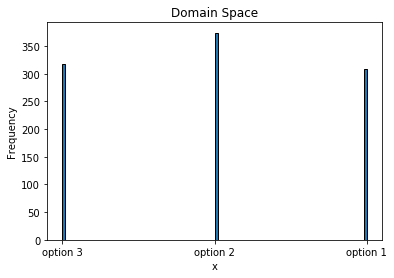

In [9]:
space = Categorical(['option 1', 'option 2', 'option 3'], name='x', prior=None, transform=None)

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

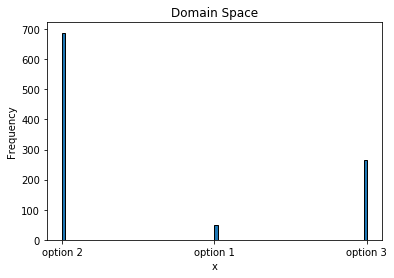

In [10]:
space = Categorical(['option 1', 'option 2', 'option 3'], name='x', prior=[0.05, 0.7, 0.25], transform=None)

samples = space.rvs(n_samples=1000)
plot_samples(samples, 100)

In [11]:
options = ['option 1', 'option 2', 'option 3']
space = Categorical(options, name='x', prior=None, transform='identity')

trans = space.transform(options)
print('Identity transform:')
print('input={}'.format(options))
print('output={}'.format(trans))

Identity transform:
input=['option 1', 'option 2', 'option 3']
output=['option 1', 'option 2', 'option 3']


In [12]:
options = ['option 1', 'option 2', 'option 3']
space = Categorical(options, name='x', prior=None, transform='onehot')

trans = space.transform(options)
print('Onehot transform:')
print('input={}'.format(options))
print('output={}'.format(trans))

Onehot transform:
input=['option 1', 'option 2', 'option 3']
output=[[1 0 0]
 [0 1 0]
 [0 0 1]]


### The Objective function

Now time to introduce the objective function that you want to minimize. For our objective function, we will use a simple polynomial function with the goal being to find the minimu value. This function has one global minimum over the range we define it as well as one local minimum. 
<BR>

When we define the objective function, we must make sure it returns a single real-value number to minimize. If we use a metric such as accuracy, then we would have to return the negative of accuracy to tell our model to find a better accuracy! We can also return a dictionary (we will see this later) where one of the keys must be "loss".

In [17]:
import numpy as np

def obj_func(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -25, 32, 7, -2, -200])
    return f(x[0]) * 0.05

Minimum of -139.6120 occurs at 4.5380


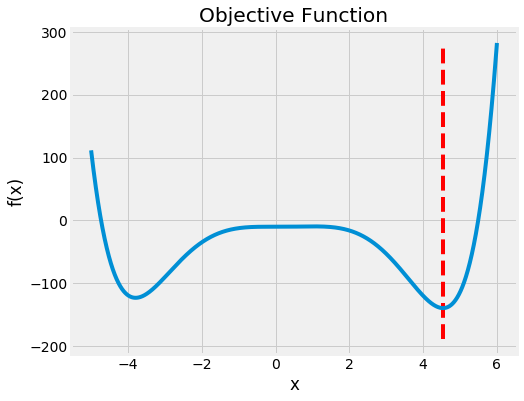

In [14]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = obj_func(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

**So we are looking to find optimization methods that arrive fast at the result 
Minimum of -139.6120 occurs at 4.5380**

### Optimization Methods

There are four optimization algorithms to try.

**dummy_minimize**

You can just run a simple random search over the parameters. Nothing fancy here but it is useful to have this option with the same API.

**forest_minimize and gbrt_minimize**

The idea behind this approach is to estimate the user-defined objective function with the random forest, extra trees, or gradient boosted trees regressor.

After each run of hyperparameters on the objective function, the algorithm needs to make an educated guess which set of hyperparameters is the most likely to improve the score and should be tried in the next run. It is done by getting regressor predictions on many points (hyperparameter sets) and choosing the point that is the best guess based on the so-called acquisition function.

There are quite a few acquisition function options to choose from:

EI and PI: Negative expected improvement and Negative probability improvement. If you choose one of those you should tweak the xi parameter as well. Basically, when your algorithm is looking for the next set of hyperparameters, you can decide how small of the expected improvement you are willing to try on the actual objective function. The higher the value, the bigger the improvement (or probability of improvement) your regressor expects.
LCB: Lower confidence bound. In this case, you want to choose your next point carefully, limiting the downside risk. You can decide how much risk you want to take at each run. By making the kappa parameter small you lean toward exploitation of what you know, by making it larger you lean toward exploration of the search space.
There are also options EIPS and PIPS which take into account both the score produced by the objective function and the execution time.

**gp_minimize**

Instead of using the tree regressors, the objective function is approximated by the Gaussian process.

From a user perspective, the added value of this method is that instead of deciding beforehand on one of the acquisition functions, you can let the algorithm select the best one of EI, PI, and LCB at every iteration. Just set acquisition function to gp_hedge and try it out.

One more thing to consider is the optimization method used at each iteration, sampling or lbfgs. For both of them, the acquisition function is calculated over randomly selected number of points (n_points) in the search space. If you go with sampling, then the point with the lowest value is selected. If you choose lbfgs, the algorithm will take some number (n_restarts_optimizer) of the best, randomly tried points, and will run the lbfgs optimization starting at each of them. So basically the lbfgs method is just an improvement over the sampling method if you don’t care about the execution time.

In [15]:
# Defining our space
SPACE = [Real(-5.0, 6.0, name='x', prior='uniform')]

In [150]:
import matplotlib.pyplot as plt

def plot_results(x_list, y_list, y1_list, max_x=800, max_y=250):
    fig, host = plt.subplots()
    fig.subplots_adjust(right=2.1, top=1.5)

    par1 = host.twinx()

    acc0 = 1-4.5380+4.50404
    acc1 = 1-4.542559+4.50404
    acc2 = 1-4.538176+4.50404
    p1, = host.plot(x_list, y_list, "b-", label="Accuracy")
    p2, = par1.plot(x_list, y1_list, "r-", label="Time")

    host.set_xlim(25, max_x)
    host.set_ylim(0.9, 1.0)
    par1.set_ylim(0, max_y)

    host.set_xlabel("No. of Calls")
    host.set_ylabel("Accuracy (%)")
    par1.set_ylabel("Time (s)")

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2]

    host.legend(lines, [l.get_label() for l in lines])

    plt.show()

#### dummy_minimize
Random search by uniform sampling within the given bounds.

In [53]:
%%time

from skopt import dummy_minimize 

res_dummy = dummy_minimize(obj_func, dimensions=SPACE, n_calls=6400, random_state=11)
print('Global min: {}, Global min value: {}; Estimated min: {}, Estimated value: {}'.format('4.5380', '-139.6120', res_dummy.x, res_dummy.fun))

# calls = 25-50-100-200: Global min: 4.5380, Global min value: -139.6120; Estimated min: [4.504046558763719], Estimated value: -139.50665419853954
# Wall time: 7 ms, 13 ms, 26 ms, 52 ms

# calls = 400-800: Global min: 4.5380, Global min value: -139.6120; Estimated min: [4.5425590414426775], Estimated value: -139.61024095137466
# Wall time: 106 ms, 219 ms

# calls = 1600-6400: Global min: 4.5380, Global min value: -139.6120; Estimated min: [4.538176061592594], Estimated value: -139.61203406709947
# Wall time: 528 ms, 3840 ms

Global min: 4.5380, Global min value: -139.6120; Estimated min: [4.538176061592594], Estimated value: -139.61203406709947
Wall time: 3.84 s


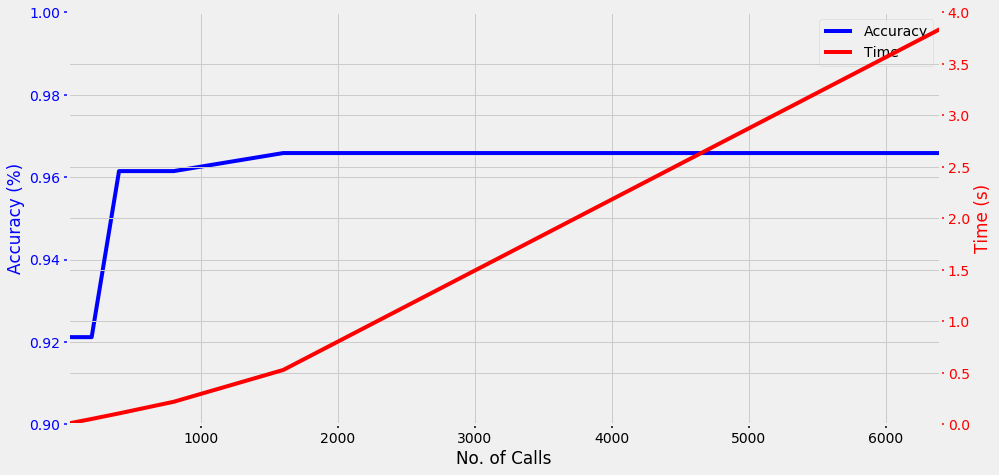

In [206]:
acc0 = 1-4.5380+4.50404
acc1 = 1-4.542559+4.50404
acc2 = 1-4.538176+4.50404
res_dummy_x_list = [0, 25, 50, 100, 200, 400, 800, 1600, 6400]
res_dummy_y_list = [0, acc, acc, acc, acc, acc1, acc1, acc2, acc2]
res_dummy_y1_list = [0, 0.007, 0.013, 0.026, 0.052, 0.106, 0.219, 0.528, 3.840]
plot_results(res_dummy_x_list, res_dummy_y_list, res_dummy_y1_list, 6400, 4)

#### forest_minimize
Sequential optimisation using decision trees.

In [212]:
%%time

from skopt import forest_minimize 

res_for_et_LCB = forest_minimize(obj_func, dimensions=SPACE, base_estimator='ET', acq_func='LCB', n_calls=800, random_state=13)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_et_LCB.x, res_for_et_LCB.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100-200-400-800: Global min: [4.453774162136494], Global value: -138.98517617229638; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.71 s, 7.13 s, 70 s, 144 s


E:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Global min: [4.453774162136494], Global value: -138.98517617229638; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 2min 24s


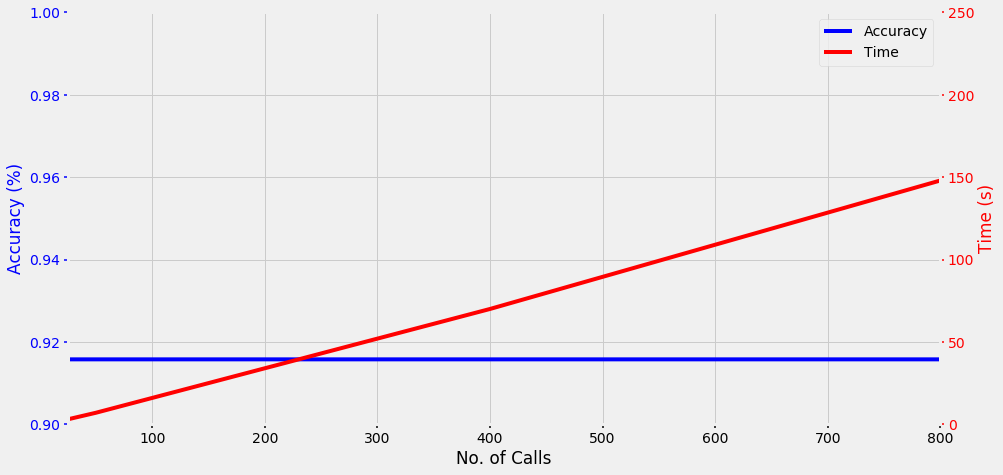

In [234]:
acc = 1-4.5380+4.45377
res_for_et_LCB_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_et_LCB_y_list = [0, acc, acc, acc, acc, acc, acc]
res_for_et_LCB_y1_list = [0, 3, 7, 16, 34, 70, 148]
plot_results(res_for_et_LCB_x_list, res_for_et_LCB_y_list, res_for_et_LCB_y1_list)

In [217]:
%%time

from skopt import forest_minimize 

res_for_et_EI = forest_minimize(obj_func, dimensions=SPACE, base_estimator='ET', n_calls=200, acq_func='EI', xi=0.003, random_state=17)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_et_EI.x, res_for_et_EI.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100: Global min: [4.459164887189491], Global value: -139.06103320089818; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.73 s, 6.97 s, 16s, 

# Calls=200-400-800: Global min: [4.60002004241654], Global value: -139.24629016636277; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 33.9 s, 71 s, 146 s

Global min: [4.60002004241654], Global value: -139.24629016636277; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 34.5 s


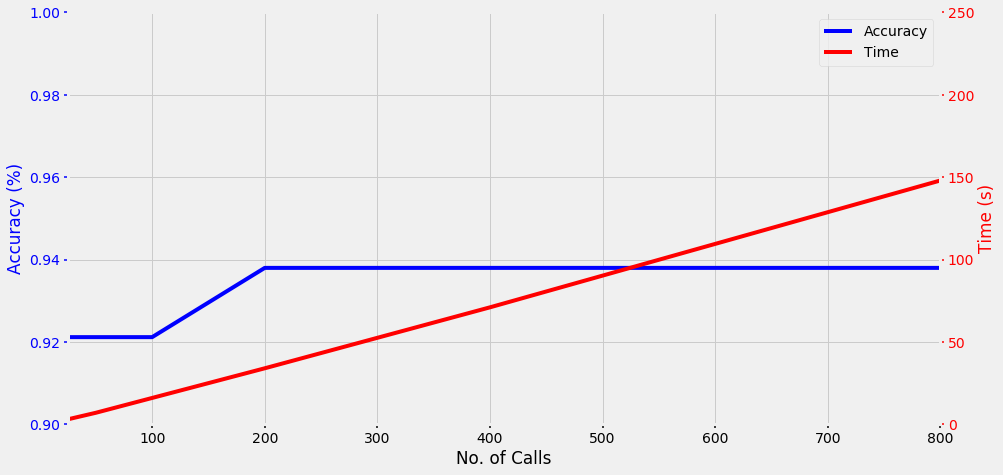

In [233]:
acc = 1-4.5380+4.459164
acc1 = 1-4.60002+4.5380
res_for_et_EI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_et_EI_y_list = [0, acc, acc, acc, acc1, acc1, acc1]
res_for_et_EI_y1_list = [0, 3, 7, 16, 34, 71, 148]
plot_results(res_for_et_EI_x_list, res_for_et_EI_y_list, res_for_et_EI_y1_list)

In [242]:
%%time

from skopt import forest_minimize 

res_for_et_PI = forest_minimize(obj_func, dimensions=SPACE, base_estimator='ET', n_calls=800, acq_func='PI', xi=0.003, random_state=17)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_et_PI.x, res_for_et_PI.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100-200-: Global min: [4.510947791983865], Global value: -139.5447204668687; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.69 s, 6.94 s, 15.5 s, 32.7 s

# Calls = 400: Global min: [4.511041697277037], Global value: -139.54518075934192; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 67s

# Calls: 800: Global min: [4.511131414612521], Global value: -139.5456190714709; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 137s

Global min: [4.511131414612521], Global value: -139.5456190714709; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 2min 17s


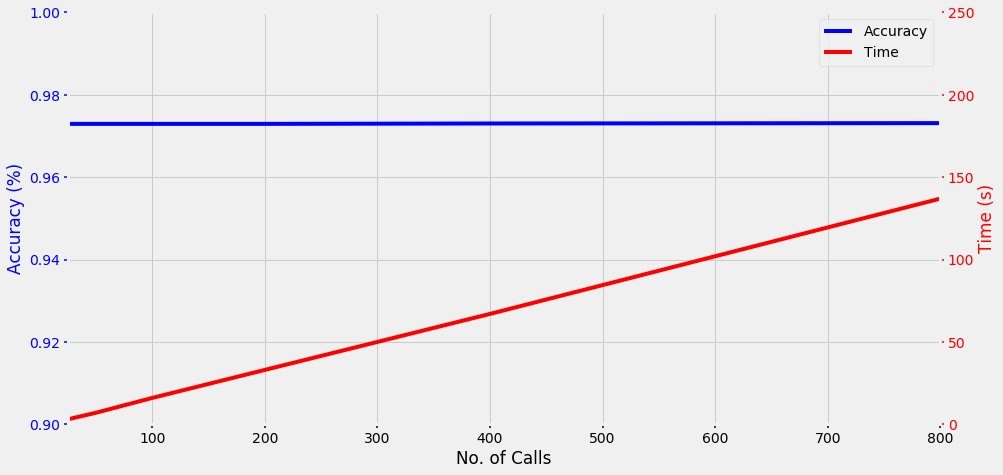

In [246]:
acc = 1-4.5380+4.51094779
acc1 = 1-4.5380+4.511041697
acc2 = 1-4.5380+4.5111314

res_for_et_PI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_et_PI_y_list = [0, acc, acc, acc, acc, acc1, acc2]
res_for_et_PI_y1_list = [0, 3, 7, 16, 33, 67, 137]
plot_results(res_for_et_PI_x_list, res_for_et_PI_y_list, res_for_et_PI_y1_list)

In [249]:
%%time

from skopt import forest_minimize 

res_for_rf_LCB = forest_minimize(obj_func, dimensions=SPACE, base_estimator='RF', acq_func='LCB', n_calls=100, random_state=13)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_rf_LCB.x, res_for_rf_LCB.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100-: Global min: [4.52764045275884], Global value: -139.6018831437804; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 3.19 s, 7.8 s, 19.7 s

# Calls = 200: Global min: [4.538555887914111], Global value: -139.61201943004184; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 44.6 s

# Calls = 400: Global min: [4.538218472375574], Global value: -139.61203375421456; Estimated min: 4.5380, Estimated value: -139.6120
#Wall time: 96s 

# Calls: 800: Global min: [4.538161358762885], Global value: -139.61203409804133; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 217s

Global min: [4.52764045275884], Global value: -139.6018831437804; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 19.9 s


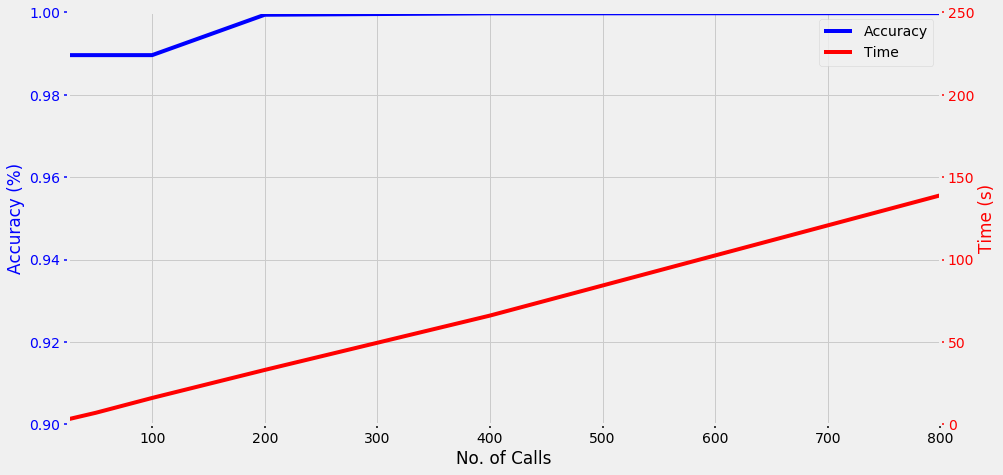

In [250]:
acc = 1-4.5380+4.52764045
acc1 = 1-4.5385558+4.5380
acc2 = 1-4.53821847+4.5380
acc3 = 1-4.53816135+4.5380

res_for_rf_LCB_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_rf_LCB_y_list = [0, acc, acc, acc, acc1, acc2, acc3]
res_for_rf_LCB_y1_list = [0, 3, 7, 16, 33, 66, 139]
plot_results(res_for_rf_LCB_x_list, res_for_rf_LCB_y_list, res_for_rf_LCB_y1_list)

In [ ]:
%%time

from skopt import forest_minimize 

res_for_rf_EI = forest_minimize(obj_func, dimensions=SPACE, base_estimator='RF', acq_func='EI', n_calls=800, random_state=13)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_rf_EI.x, res_for_rf_EI.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100-200: Global min: [4.52764045275884], Global value: -139.6018831437804; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 3.11 s, 8.32 s, 18.9 s, 42.3 s

# Calls = 400: Global min: [4.547924439718798], Global value: -139.6031786785981; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 105 s

# Calls = 800: Global min: [4.536992925238733], Global value: -139.61190901345913; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 248s

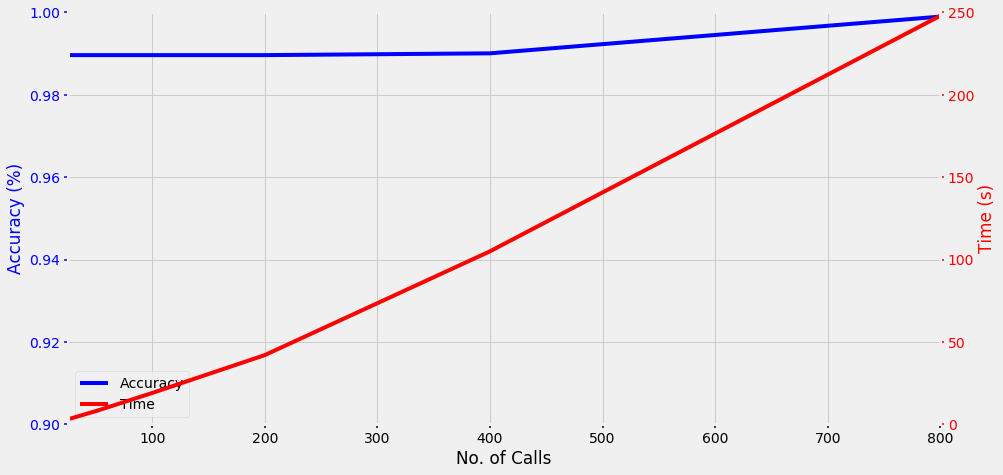

In [257]:
acc = 1-4.5380+4.52764045
acc1 = 1-4.547924439+4.5380
acc2 = 1-4.5380+4.5369929

res_for_rf_EI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_rf_EI_y_list = [0, acc, acc, acc, acc, acc1, acc2]
res_for_rf_EI_y1_list = [0, 3, 8, 19, 42, 105, 248]
plot_results(res_for_rf_EI_x_list, res_for_rf_EI_y_list, res_for_rf_EI_y1_list)

In [263]:
%%time

from skopt import forest_minimize 

res_for_rf_PI = forest_minimize(obj_func, dimensions=SPACE, base_estimator='RF', acq_func='PI', n_calls=800, random_state=13)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_for_rf_PI.x, res_for_rf_PI.fun, '4.5380', '-139.6120'))

# Calls = 25-50: Global min: [4.607525317156755], Global value: -139.15023463236716; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 3.26 s, 8.29 s

# Calls = 100-200: Global min: [4.5253332175671], Global value: -139.59696020099298; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 18.6 s, 39.4 s

# Calls = 400-800: Global min: [4.538258609565128], Global value: -139.6120331521919; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 87s, 190 s

Global min: [4.538258609565128], Global value: -139.6120331521919; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 3min 10s


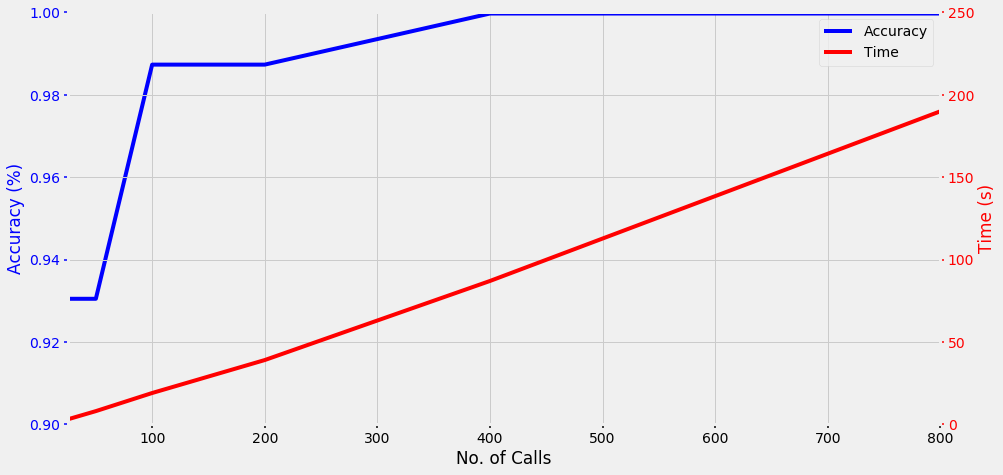

In [264]:
acc = 1-4.6075253+4.5380
acc1 = 1-4.5380+4.5253332
acc2 = 1-4.538258609+4.5380

res_for_rf_PI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_for_rf_PI_y_list = [0, acc, acc, acc1, acc1, acc2, acc2]
res_for_rf_PI_y1_list = [0, 3, 8, 19, 39, 87, 190]
plot_results(res_for_rf_PI_x_list, res_for_rf_PI_y_list, res_for_rf_PI_y1_list)

#### gbrt_minimize
Sequential optimization using gradient boosted trees.

In [68]:
%%time

from skopt import gbrt_minimize 

res_gbr_LCB = gbrt_minimize(obj_func, dimensions=SPACE, acq_func="LCB", n_calls=800, random_state=19)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gbr_LCB.x, res_gbr_LCB.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [4.569665955737658], Global value: -139.51874743238736; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.28 s

# Calls = 50: Global min: [4.511318519096209], Global value: -139.54652859921947; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 5.77 s

# Calls = 100: Global min: [4.535608801449536], Global value: -139.6114353434454; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 13.3 s

# Calls = 200-400: Global min: [4.537766420477144], Global value: -139.61201999639772; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 29.2 s, 62 s

# Calls = 800: Global min: [4.5381857961993965], Global value: -139.61203402465048; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 133 s

Global min: [4.5381857961993965], Global value: -139.61203402465048; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 2min 13s


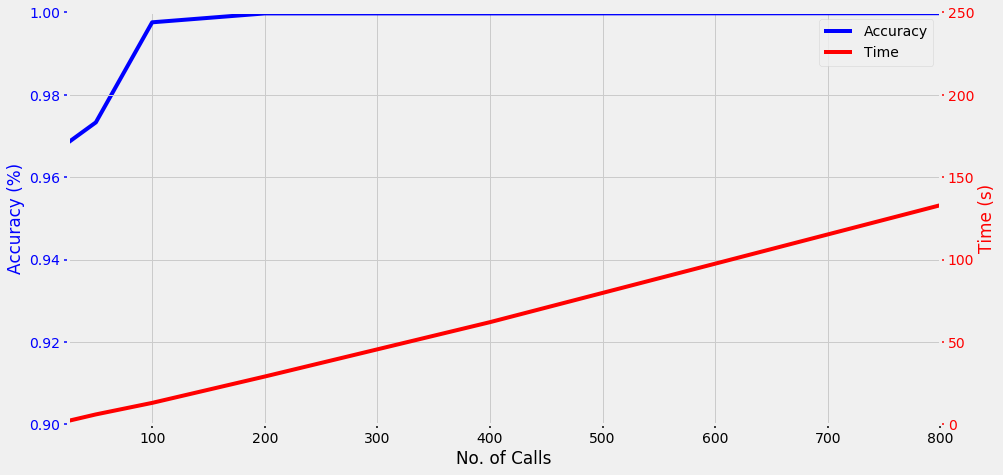

In [265]:
acc25 = 1-4.56966+4.5380
acc50 = 1-4.5380+4.51131
acc100 = 1-4.5380+4.535608
acc200_400 = 1-4.5380+4.537766
acc800 = 1-4.53818+4.5380
res_gbr_LCB_x_list = [0, 25, 50, 100, 200, 400, 800]
res_gbr_LCB_y_list = [0, acc25, acc50, acc100, acc200_400, acc200_400, acc800]
res_gbr_LCB_y1_list = [0, 2, 6, 13, 29, 62, 133]
plot_results(res_gbr_LCB_x_list, res_gbr_LCB_y_list, res_gbr_LCB_y1_list)

In [266]:
%%time

from skopt import gbrt_minimize 

res_gbr_EI = gbrt_minimize(obj_func, dimensions=SPACE, acq_func="EI", n_calls=100, xi=0.002, random_state=19)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gbr_EI.x, res_gbr_EI.fun, '4.5380', '-139.6120'))

# Calls = 25-50-100: Global min: [4.536346883516247], Global value: -139.61173181237473; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.35 s, 6.35 s, 13.9 s

# Calls = 200: Global min: [4.537020223732178], Global value: -139.61191480804456; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 29.6 s

# Calls = 400: Global min: [4.538024949283866], Global value: -139.61203248221554; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 63s

# Calls = 800: Global min: [4.538184261998023], Global value: -139.61203403250212; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 130s

Global min: [4.536346883516247], Global value: -139.61173181237473; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 13.9 s


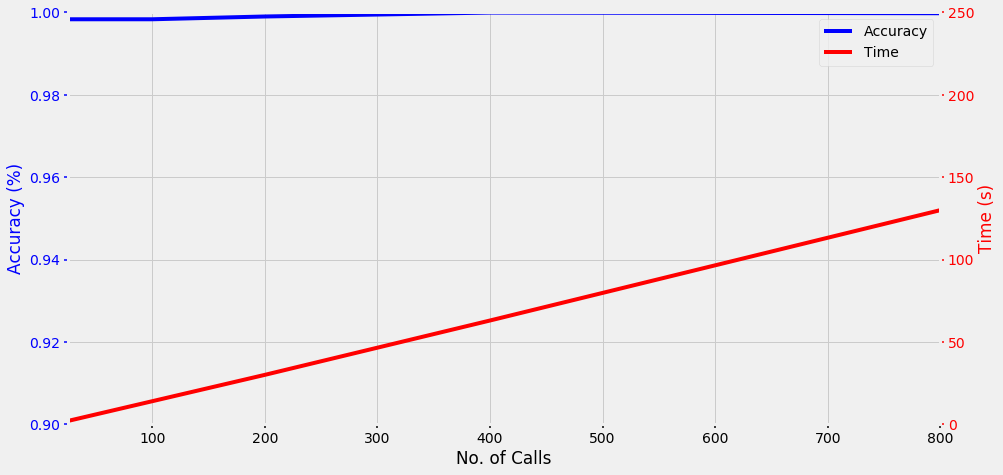

In [269]:
acc25_50_100 = 1-4.5380+4.53634688
acc200 = 1-4.5380+4.5370202
acc400 = 1-4.538024949+4.5380
acc800 = 1-4.53818426+4.5380
res_gbr_EI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_gbr_EI_y_list = [0, acc25_50_100, acc25_50_100, acc25_50_100, acc200, acc400, acc800]
res_gbr_EI_y1_list = [0, 2, 6, 14, 30, 63, 130]
plot_results(res_gbr_EI_x_list, res_gbr_EI_y_list, res_gbr_EI_y1_list)

In [270]:
%%time

from skopt import gbrt_minimize 

res_gbr_PI = gbrt_minimize(obj_func, dimensions=SPACE, acq_func="PI", n_calls=50, xi=0.002, random_state=19)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gbr_PI.x, res_gbr_PI.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [-3.7909333207086604], Global value: -123.22377887682826; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2.32 s

# Calls = 50: Global min: [-3.7940265486346725], Global value: -123.22446172985352; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 5.89 s

# Calls = 100-200: Global min: [-3.7937813521721084], Global value: -123.22446628493515; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 13.2 s, 28.1 s, 

# Calls = 400: Global min: [4.541278895906164], Global value: -139.61113292736204; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 1min 1s

# Calls = 800: Global min: [4.538231530519985], Global value: -139.6120335910028; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2min 8s

Global min: [-3.7940265486346725], Global value: -123.22446172985352; Estimated min: 4.5380, Estimated value: -139.6120
Wall time: 6.07 s


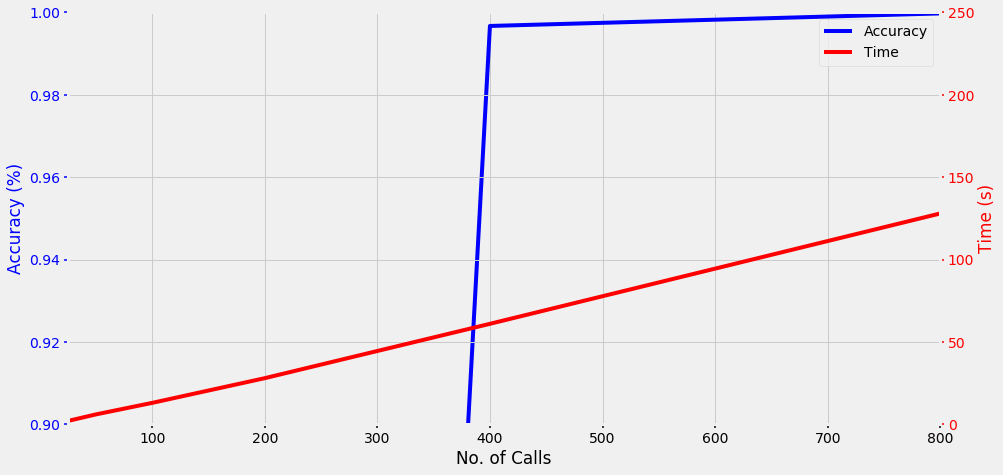

In [271]:
acc25_200 = 0
acc400 = 1-4.54127889+4.5380
acc800 = 1-4.53823153+4.5380
res_gbr_PI_x_list = [0, 25, 50, 100, 200, 400, 800]
res_gbr_PI_y_list = [0, acc25_200, acc25_200, acc25_200, acc25_200, acc400, acc800]
res_gbr_PI_y1_list = [0, 2, 6, 13, 28, 61, 128]
plot_results(res_gbr_PI_x_list, res_gbr_PI_y_list, res_gbr_PI_y1_list)

#### gp_minimize
Bayesian optimization using Gaussian Processes.

In [172]:
#%%time

from skopt import gp_minimize 

res_gb_LCB = gp_minimize(obj_func, dimensions=SPACE, acq_func="LCB", n_calls=200, xi=0.005, random_state=23)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gb_LCB.x, res_gb_LCB.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [4.538090119580923], Global value: -139.61203368275127; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 5.28 s

# Calls = 50: Global min: [4.538117283432106], Global value: -139.61203395162815; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 14.6 s

# Calls = 100: Global min: [4.538140031064463], Global value: -139.61203407198153; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 41.6 s

# Calls = 200: Global min: [4.538174446371807], Global value: -139.6120340724503; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 2min 40s

E:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Global min: [4.538174446371807], Global value: -139.6120340724503; Estimated min: 4.5380, Estimated value: -139.6120


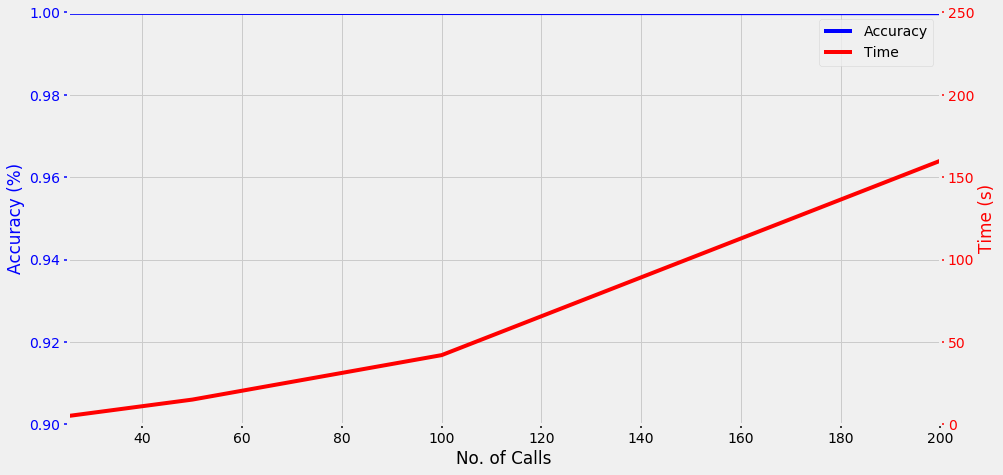

In [272]:
acc25 = 1-4.538090119+4.5380
acc50 = 1-4.53811728+4.5380
acc100 = 1-4.538140031+4.5380
acc200 = 1-4.53817444+4.5380
res_gb_LCB_x_list = [0, 25, 50, 100, 200]
res_gb_LCB_y_list = [0, acc25, acc50, acc100, acc200]
res_gb_LCB_y1_list = [0, 5, 15, 42, 160]
plot_results(res_gb_LCB_x_list, res_gb_LCB_y_list, res_gb_LCB_y1_list, 200)

In [169]:
#%%time

from skopt import gp_minimize 

res_gb_EI = gp_minimize(obj_func, dimensions=SPACE, acq_func="EI", n_calls=200, xi=0.005, random_state=23)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gb_EI.x, res_gb_EI.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [4.55237469989398], Global value: -139.59322371093657; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 4.02 s

# Calls = 50: Global min: [4.533212174719335], Global value: -139.60978271476048; Estimated min: 4.5380, Estimated value: -139.6120
#Wall time: 10.7 s

# Calls = 100: Global min: [4.538189298345799], Global value: -139.6120340050991; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 42.3 s

# Calls = 200: Global min: [4.538181772780437], Global value: -139.61203404431657; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 3min 29s

Global min: [4.538181772780437], Global value: -139.61203404431657; Estimated min: 4.5380, Estimated value: -139.6120


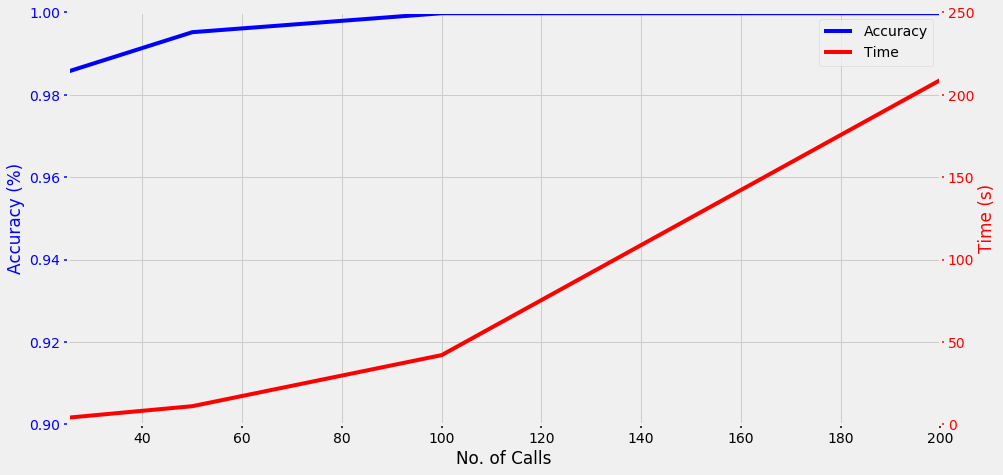

In [274]:
acc25 = 1-4.55237469+4.5380
acc50 = 1-4.5380+4.53321217
acc100 = 1-4.5381892+4.5380
acc200 = 1-4.5381817+4.5380
res_gb_EI_x_list = [0, 25, 50, 100, 200]
res_gb_EI_y_list = [0, acc25, acc50, acc100, acc200]
res_gb_EI_y1_list = [0, 4, 11, 42, 209]
plot_results(res_gb_EI_x_list, res_gb_EI_y_list, res_gb_EI_y1_list, 200)

In [159]:
#%%time

from skopt import gp_minimize 

res_gb_PI = gp_minimize(obj_func, dimensions=SPACE, acq_func="PI", n_calls=200, xi=0.005, random_state=23)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gb_PI.x, res_gb_PI.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [4.5374920079885666], Global value: -139.6119932509984; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 7.14 s

# Calls = 50-100: Global min: [4.5380516507103685], Global value: -139.61203306890917; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 19.2 s, 57.4 s

# Calls = 200: Global min: [4.53815550085768], Global value: -139.61203409924977; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 3min 25s

Global min: [4.53815550085768], Global value: -139.61203409924977; Estimated min: 4.5380, Estimated value: -139.6120


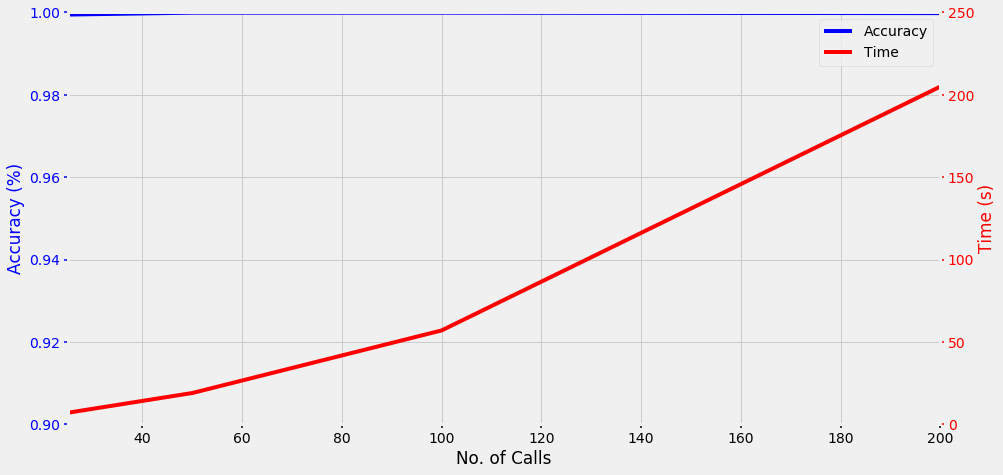

In [275]:
acc25 = 1-4.5380+4.53749200
acc50_100 = 1-4.53805165+4.5380
acc200 = 1-4.5381555+4.5380
res_gb_PI_x_list = [0, 25, 50, 100, 200]
res_gb_PI_y_list = [0, acc25, acc50_100, acc50_100, acc200]
res_gb_PI_y1_list = [0, 7, 19, 57, 205]
plot_results(res_gb_PI_x_list, res_gb_PI_y_list, res_gb_PI_y1_list, 200)

In [157]:
#%%time

from skopt import gp_minimize 

res_gp_hedge = gp_minimize(obj_func, dimensions=SPACE, acq_func="gp_hedge", n_calls=200, xi=0.005, random_state=23)
print('Global min: {}, Global value: {}; Estimated min: {}, Estimated value: {}'.format(res_gp_hedge.x, res_gp_hedge.fun, '4.5380', '-139.6120'))

# Calls = 25: Global min: [4.512734151060563], Global value: -139.55320982060218; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 6.34 s

# Calls = 50: Global min: [4.538310089323227], Global value: -139.61203194454205; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 26.8 s

# Calls = 100: Global min: [4.538185626106145], Global value: -139.6120340255424; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 1min 40s

# Calls = 200: Global min: [4.538153234418141], Global value: -139.6120340980174; Estimated min: 4.5380, Estimated value: -139.6120
# Wall time: 7min 2s

Global min: [4.538153234418141], Global value: -139.6120340980174; Estimated min: 4.5380, Estimated value: -139.6120


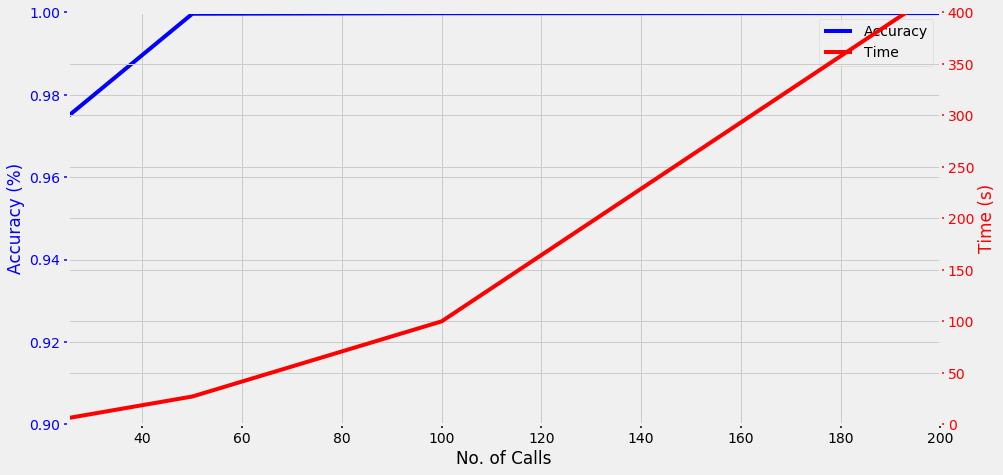

In [277]:
acc25 = 1-4.5380+4.51273415
acc50 = 1-4.538310089+4.5380
acc100 = 1-4.53818562+4.5380
acc200 = 1-4.53815323+4.5380
res_gb_gp_hedge_x_list = [0, 25, 50, 100, 200]
res_gb_gp_hedge_y_list = [0, acc25, acc50, acc100, acc200]
res_gb_gp_hedge_y1_list = [0, 6, 27, 100, 422]
plot_results(res_gb_gp_hedge_x_list, res_gb_gp_hedge_y_list, res_gb_gp_hedge_y1_list, 200, 400)

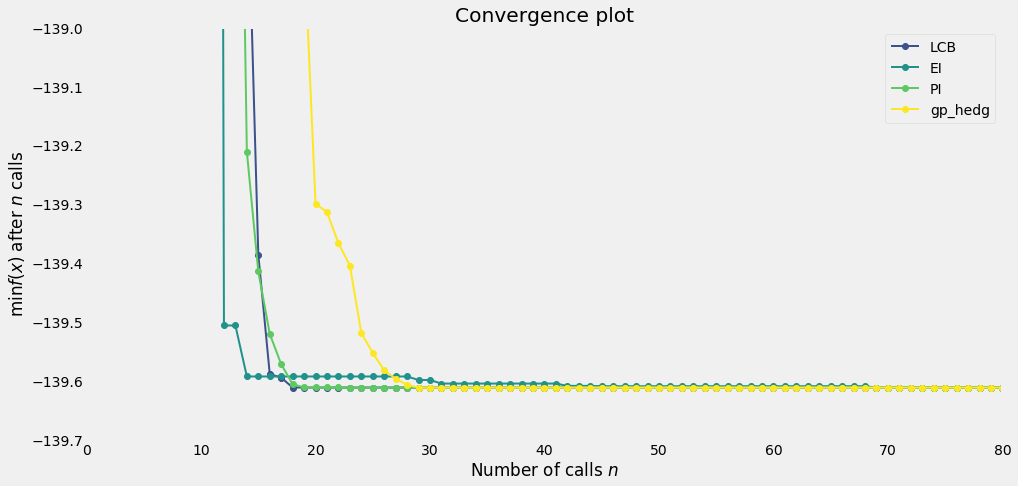

In [287]:
import skopt.plots

plot = skopt.plots.plot_convergence(("LCB", res_gb_LCB), ("EI", res_gb_EI), ("PI", res_gb_PI), ("gp_hedg", res_gp_hedge))
plot.set_xlim(0, 80)
plot.set_ylim(-139.7, -139)

plot.figure.subplots_adjust(right=2.2, top=1.5)

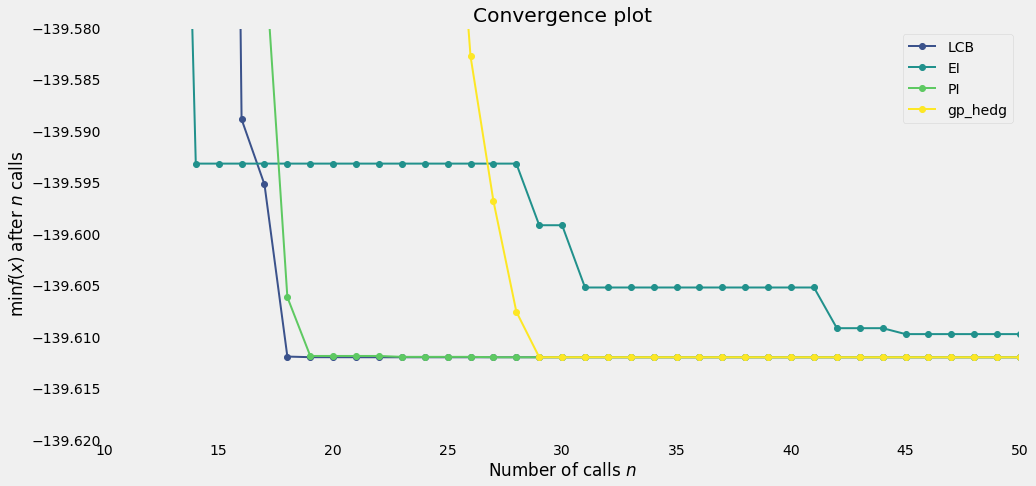

In [290]:
plot_closeup = skopt.plots.plot_convergence(("LCB", res_gb_LCB), ("EI", res_gb_EI), ("PI", res_gb_PI), ("gp_hedg", res_gp_hedge))
plot_closeup.set_xlim(10, 50)
plot_closeup.set_ylim(-139.62, -139.58)

plot_closeup.figure.subplots_adjust(right=2.2, top=1.5)

### Summary

In [291]:
# dummy_minimize
#res_dummy_x_list = [0, 25, 50, 100, 200, 400, 800, 1600, 6400]
#res_dummy_y_list = [0, acc, acc, acc, acc, acc1, acc1, acc2, acc2]
#res_dummy_y1_list = [0, 0.007, 0.013, 0.026, 0.052, 0.106, 0.219, 0.528, 3.840]
#plot_results(res_dummy_x_list, res_dummy_y_list, res_dummy_y1_list, 6400, 4)

# forest_minimize
#res_for_et_PI_x_list = [0, 25, 50, 100, 200, 400, 800]
#res_for_et_PI_y_list = [0, acc, acc, acc, acc, acc1, acc2]
#res_for_et_PI_y1_list = [0, 3, 7, 16, 33, 67, 137]
#plot_results(res_for_et_PI_x_list, res_for_et_PI_y_list, res_for_et_PI_y1_list)

#res_for_rf_LCB_x_list = [0, 25, 50, 100, 200, 400, 800]
#res_for_rf_LCB_y_list = [0, acc, acc, acc, acc1, acc2, acc3]
#res_for_rf_LCB_y1_list = [0, 3, 7, 16, 33, 66, 139]
#plot_results(res_for_rf_LCB_x_list, res_for_rf_LCB_y_list, res_for_rf_LCB_y1_list)

# gbrt_minimize
#res_gbr_EI_x_list = [0, 25, 50, 100, 200, 400, 800]
#res_gbr_EI_y_list = [0, acc25_50_100, acc25_50_100, acc25_50_100, acc200, acc400, acc800]
#res_gbr_EI_y1_list = [0, 2, 6, 14, 30, 63, 130]
#plot_results(res_gbr_EI_x_list, res_gbr_EI_y_list, res_gbr_EI_y1_list)

# gp_minimize
#res_gb_LCB_x_list = [0, 25, 50, 100, 200]
#res_gb_LCB_y_list = [0, acc25, acc50, acc100, acc200]
#res_gb_LCB_y1_list = [0, 5, 15, 42, 160]
#plot_results(res_gb_LCB_x_list, res_gb_LCB_y_list, res_gb_LCB_y1_list, 200)

x_lists = [res_dummy_x_list, res_for_et_PI_x_list, res_for_rf_LCB_x_list, res_gbr_EI_x_list, res_gb_LCB_x_list]
y_lists = [res_dummy_y_list, res_for_et_PI_y_list, res_for_rf_LCB_y_list, res_gbr_EI_y_list, res_gb_LCB_y_list]
y1_lists = [res_dummy_y1_list, res_for_et_PI_y1_list, res_for_rf_LCB_y1_list, res_gbr_EI_y1_list, res_gb_LCB_y1_list]


In [331]:
def plot_result_lists(x_lists, y_lists, y1_lists, accuracy_min=0.9, accuracy_max=1.01, max_x=800, max_y=250):
    fig, host = plt.subplots()
    fig.subplots_adjust(right=2.1, top=1.5)

    par1 = host.twinx()
    
    lines = ['Dummy', 'Extra Trees (PI)', 'Randon Forest (LCB)', 'Gradient Boosted (EI)', 'Gaussian Processes (LCB)']
    
    linestyles = ['-', '--', '-.', ':', '-']
    markers = ['*', '>', '^', 'o', 'v']
    for i in range(len(x_lists)):
        x_list = x_lists[i]
        y_list = y_lists[i]
        y1_list = y1_lists[i]

        p1, = host.plot(x_list, y_list, color='red', linestyle=linestyles[i], marker=markers[i], markersize=12, label="Accuracy")
        p2, = par1.plot(x_list, y1_list,  color='blue', linestyle=linestyles[i], marker=markers[i], markersize=12, label="Time")

    host.set_xlim(25, max_x)
    host.set_ylim(accuracy_min, accuracy_max)
    par1.set_ylim(0, max_y)

    host.set_xlabel("No. of Calls")
    host.set_ylabel("Accuracy (%)")
    par1.set_ylabel("Time (s)")

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    host.legend(lines)

    plt.show()

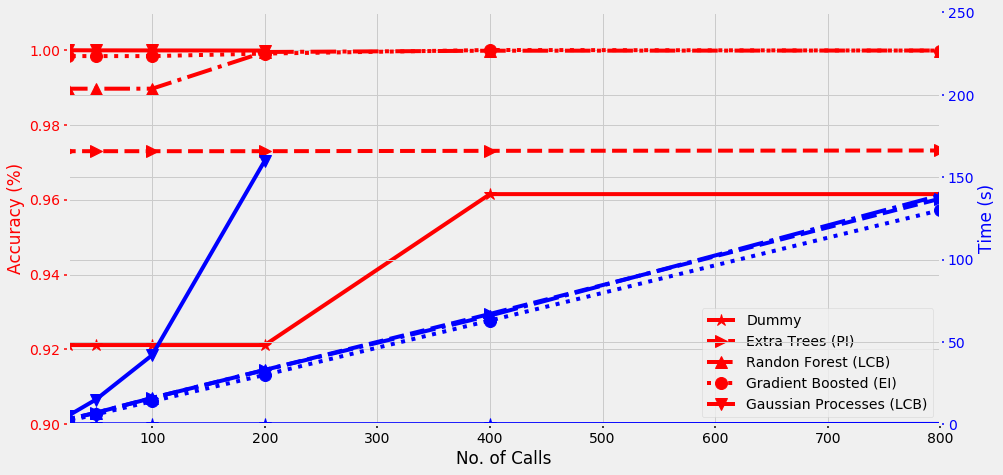

In [332]:
plot_result_lists(x_lists, y_lists, y1_lists)

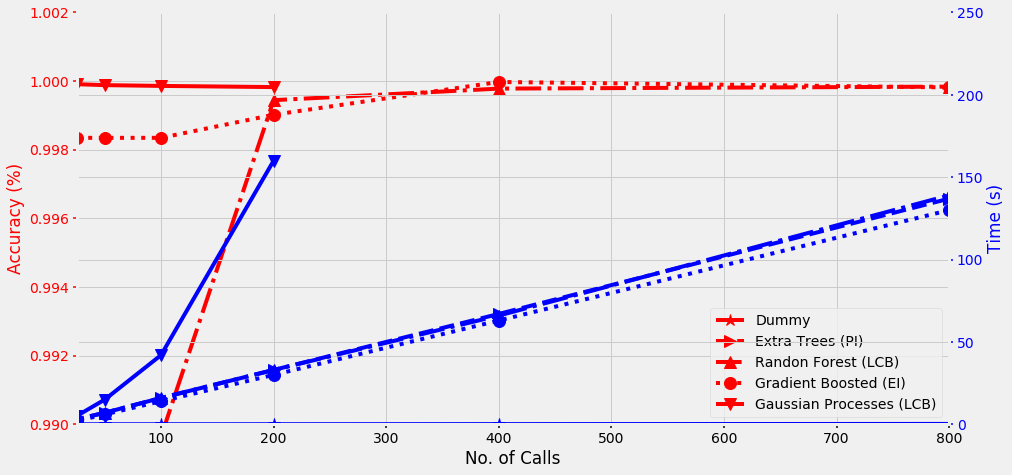

In [340]:
plot_result_lists(x_lists, y_lists, y1_lists, 0.99, 1.002)